In [1]:
import nltk
import numpy as np
from multiprocessing import Process
from multiprocessing import Manager
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from tqdm import tqdm
import pandas
import matplotlib.pyplot as plt
import pickle
import tqdm
#!pip install https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.1.0/ru_core_news_sm-3.1.0.tar.gz

[nltk_data] Downloading package punkt to /home/maximus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Данные

In [2]:
df_data = pandas.read_csv("../data/Dude_tinkoff_new.csv")

Таблица для сбора общей статистики:

In [3]:
total_stat = pandas.DataFrame(columns=['models', 'class_size']) 

Таблица для сбора общей статистики по авторам:

In [75]:
df_auth_stat = pandas.DataFrame(columns=['models', 'number_of_authors']) 

Таблица с данными

In [4]:
df_data.head()

,Unnamed: 0,author_id,author_url,author_name,text,reply_count,top_level,index,publishedAt,updateAt,likeCount
0,0,UC2yzgGYTEDdRNVkayjW1C2w,http://www.youtube.com/channel/UC2yzgGYTEDdRNV...,Владимир Виноградов,"Вот и до Яндекса добрались. \nЮрий Д., пора Ар...",0,0.0,0.0,2022-12-11T16:37:04Z,2022-12-11T16:37:04Z,0.0
1,1,UCg9iwvHlL3awmOHNHsBFEUA,http://www.youtube.com/channel/UCg9iwvHlL3awmO...,Dmitry Gaskov,"А где пометка ""На правах рекламы""?",0,0.0,1.0,2022-12-11T09:51:29Z,2022-12-11T09:51:29Z,0.0
2,2,UCdMwli0sTZ8jgLYXHTVZ8Gg,http://www.youtube.com/channel/UCdMwli0sTZ8jgL...,Sveta Teryoshkina,"Олег, живите! Вы крутой человек! Аминь!",0,0.0,2.0,2022-12-11T06:30:14Z,2022-12-11T06:30:14Z,1.0
3,3,UCBHQrudnNCELvzFu9NYADmA,http://www.youtube.com/channel/UCBHQrudnNCELvz...,Irina Bychal,"Спасибо за интервью, за адекватность.Тоже не м...",0,0.0,3.0,2022-12-11T05:51:37Z,2022-12-11T05:51:37Z,1.0
4,4,UCCZT1uuGwvTX45qOH6WgpSg,http://www.youtube.com/channel/UCCZT1uuGwvTX45...,Александр Носов,Молодец во всем! Но кажется что он запутался к...,0,0.0,4.0,2022-12-10T20:48:15Z,2022-12-10T20:48:15Z,0.0


In [5]:
df_data.shape

(93339, 11)

In [6]:
df_data["text"] = df_data["text"].astype('str')

In [7]:
df_data = df_data.dropna()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91809 entries, 0 to 93338
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   91809 non-null  object 
 1   author_id    91809 non-null  object 
 2   author_url   91809 non-null  object 
 3   author_name  91809 non-null  object 
 4   text         91809 non-null  object 
 5   reply_count  91809 non-null  object 
 6   top_level    91809 non-null  float64
 7   index        91809 non-null  float64
 8   publishedAt  91809 non-null  object 
 9   updateAt     91809 non-null  object 
 10  likeCount    91809 non-null  float64
dtypes: float64(3), object(8)
memory usage: 8.4+ MB


In [8]:
df_data[df_data["author_name"].isnull()]["Unnamed: 0"][:3]

Series([], Name: Unnamed: 0, dtype: object)

## Выделение пользователей, которые часто оставляют комменатрии

In [9]:
d = df_data.groupby(by=["author_id"], dropna=False).agg(full_text =("text","sum"), count=("author_id","count"))

Будем использовать только пользователей, которые часто комментируют (более 5 раз)

In [10]:
res = d.sort_values(by="count", ascending=False)
res = res[res["count"]>=3]

In [11]:
res[res["count"]>=2]["count"].sum()

22661

In [12]:
res.shape

(4267, 2)

In [13]:
#delete_auth = set(df_data["author_id"].to_list())- set(res.index.to_list())
auth = set(res.index.to_list())

In [14]:
df = df_data.copy()
df = df.loc[df["author_id"].isin(auth)]
train_corpus = df["text"]

In [15]:
total_stat = total_stat.append({'models':'total', 'class_size':train_corpus.shape[0]}, ignore_index=True)

/tmp/ipykernel_84837/2549823037.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_stat = total_stat.append({'models':'total', 'class_size':train_corpus.shape[0]}, ignore_index=True)


In [77]:
df_auth_stat = df_auth_stat.append({'models':'total', 'number_of_authors':df["author_id"].unique().shape[0]}, \
                                                                                            ignore_index=True)

/tmp/ipykernel_84837/969736557.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_auth_stat = df_auth_stat.append({'models':'total', 'number_of_authors':df["author_id"].unique().shape[0]}, \


## Токенизация и предобработка комментариев 

In [16]:
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
stop_words.extend(['br', 'її', 'quot', 'www', 'href', 'https', 'http', 'ru'])
stop_words.extend(stopwords.words('english'))

In [17]:
#from nltk.stem import WordNetLemmatizer
#wnl = WordNetLemmatizer()
import spacy
from gensim.utils import simple_preprocess
nlp = spacy.load("ru_core_news_sm")

def lemma(word):
    for w in nlp(word):
        return w.lemma_
def process_words(texts):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    for sent in texts:
        texts_out.append([lemma(token) for token in sent])
    # remove stopwords after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


/home/maximus/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [18]:
tokenized_text = [word_tokenize(tok) for tok in train_corpus]

In [19]:
data_ready = process_words(tokenized_text)

In [20]:
processed_corpus = [" ".join(doc[:120]) for doc in data_ready] 

In [21]:
import gc
gc.collect()

632

In [22]:
from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs

In [23]:
#from transformers import BertTokenizer
bert_config = read_json(configs.embedder.bert_embedder)
pth1 = '../bert/rubert/'
pth2 = './bert_path/cased_L-12_H-768_A-12/'
bert_config['metadata']['variables']['BERT_PATH'] = pth1

In [24]:
#bert_config

In [25]:
m = build_model(bert_config)


Some weights of the model checkpoint at /home/maximus/git/ODS_NLP_fall_2022/bert/rubert were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
from transformers import BertTokenizer

In [27]:
tokenizer = BertTokenizer.from_pretrained(pth1)

In [28]:
texts = ['Привет как дела max.', 'Я хочу, please!']
tok = tokenizer(processed_corpus)

In [29]:
tok.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [30]:
#tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = m(texts)

In [31]:
b = 10
N = len(processed_corpus)//b
result = np.zeros([len(processed_corpus),768])
for i in tqdm.tqdm(range(N)):
    #print(f'{i*N} : {(i+1)*N}')
    _, _, _, _, _, sent_mean_embs, _ = m(processed_corpus[i*b:(i+1)*b])
    result[i*b:(i+1)*b,:] = sent_mean_embs[:,:]
    #print(sent_mean_embs.shape)
    del sent_mean_embs
    

100%|███████████████████████████████████████| 2266/2266 [10:45<00:00,  3.51it/s]


In [32]:
del m

In [33]:
import torch

In [34]:
torch.cuda.is_available()

False

In [35]:
gc.collect()

0

## GMM

In [36]:
class_number = 4
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=class_number,  random_state=0).fit(result)

In [38]:
class_pred = gm.predict(result)

In [39]:
from sklearn.manifold import TSNE


In [40]:
def plot_tsne(class_number, result, class_pred):
    fig = plt.figure()
    ax = fig.add_subplot(111) 
    X_embedded = TSNE(n_components=2,  learning_rate='auto',  init='random', perplexity=5).fit_transform(result)
    colors = ['r', 'b', 'g', 'y','k']
    for i in range(class_number):
        ax.scatter(X_embedded[class_pred==i][:,0], X_embedded[class_pred==i][:,1], c=colors[i], label=f'class = {i}')
    #plt.scatter(X_embedded[pred==0][:,0], X_embedded[pred==0][:,1])
    ax.legend()
    return ax, fig, X_embedded

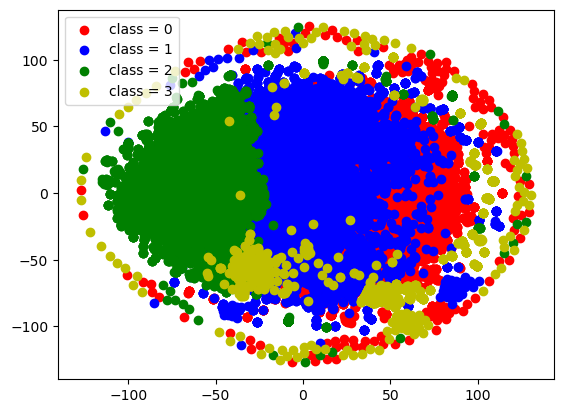

In [41]:
ax, fig1, tsne_emb = plot_tsne(class_number, result, class_pred)

In [62]:
class_with_noise = 3
fig1.savefig("../Report/pics/tsne_gmm.png")
n = train_corpus.iloc[class_pred==class_with_noise].shape[0]
print("Number element in cluster (GMM): ", n)
total_stat = total_stat.append({'models':'GMM', 'class_size':n},ignore_index=True)

Number element in cluster (GMM):  976


/tmp/ipykernel_84837/3890175370.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_stat = total_stat.append({'models':'GMM', 'class_size':n},ignore_index=True)


In [78]:
n_a = df.iloc[class_pred==class_with_noise]["author_id"].unique().shape[0]
df_auth_stat = df_auth_stat.append({'models':'GMM', 'number_of_authors':n_a},ignore_index=True)

/tmp/ipykernel_84837/2115087100.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_auth_stat = df_auth_stat.append({'models':'GMM', 'number_of_authors':n_a},ignore_index=True)


In [43]:
import codecs
LINE_WIDTH = 80
sub_indexes = np.random.randint(0,n,10)
with codecs.open("../Report/gmmclasscomment.txt","w","utf-8-sig") as f:
    #f.write("\\begin{verbatim}")
    for w in train_corpus.iloc[class_pred==class_with_noise].iloc[sub_indexes]:
        print(w)
        print("----------------------------------\n")
        f.write((w[:LINE_WIDTH] +"...\n"))
        f.write("-------------------------------------------\n")
    #f.write("\\end{verbatim}")

ск0льк0 6удет продолжаться конфликт России и Украины?И что нужно для его пекращения?О6ьективный и независимый разбор ситуации (острые,но честный факты) <a href="https://youtu.be/uySyfO7Ukek">https://youtu.be/uySyfO7Ukek</a>
----------------------------------

https://www.youtube.com/watch?v=Y3hNyPKuEUU&ab_channel=NEMAGIA
----------------------------------

☝️ To caмoе Mлaдше !8 в нuke 🥲
----------------------------------

<a href="https://www.youtube.com/watch?v=Y3hNyPKuEUU&amp;ab_channel=NEMAGIA">https://www.youtube.com/watch?v=Y3hNyPKuEUU&amp;ab_channel=NEMAGIA</a>
----------------------------------

@Anastasiia Savarovskaya я все помню
----------------------------------

☝️ To caмoе Mлaдше !8 в нuke 🥵
----------------------------------

@aligagator bezze а ты там был когда горело???
----------------------------------

☝️ To caмoе Mлaдше !8 в нuke 🥵
----------------------------------

@JnandGUK по однобоким фактам.
----------------------------------

I do not believe that Russia can 

## Выбор точек на периферии окружности

In [44]:
def plot_outside_circle(tsne_emb, r=110):
    fig = plt.figure()
    ax = fig.add_subplot(111) 
    indexes = []
    for i,p in enumerate(tsne_emb):
        if np.linalg.norm(p)>=r:
            ax.plot([p[0]],[p[1]],'ro')
            indexes.append(i)
        else:
            ax.plot([p[0]],[p[1]],'bo')
    return ax, fig, indexes
            

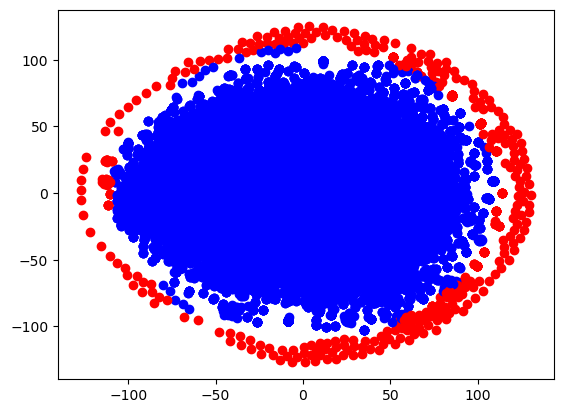

In [45]:
_, fig2, indexes = plot_outside_circle(tsne_emb)
fig2.savefig("../Report/pics/tsne_outside_circle.png")

In [64]:
n = train_corpus.iloc[indexes].shape[0]
print("Number element in cluster (outside center): ", n)
total_stat = total_stat.append({'models':'out_circle', 'class_size':n},ignore_index=True)

Number element in cluster (outside center):  491


/tmp/ipykernel_84837/4222871958.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_stat = total_stat.append({'models':'out_circle', 'class_size':n},ignore_index=True)


In [79]:
n_a = df.iloc[indexes]["author_id"].unique().shape[0]
df_auth_stat = df_auth_stat.append({'models':'out_circle', 'number_of_authors':n_a},ignore_index=True)

/tmp/ipykernel_84837/3302353349.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_auth_stat = df_auth_stat.append({'models':'out_circle', 'number_of_authors':n_a},ignore_index=True)


In [47]:
import codecs
sub_indexes = np.random.randint(0,n,10)
with codecs.open("../Report/ocentercomment.txt","w","utf-8-sig") as f:
    #f.write("\\begin{verbatim}")
    for w in train_corpus.iloc[indexes].iloc[sub_indexes]:
        print(w)
        print("----------------------------------\n")
        f.write((w[:LINE_WIDTH] +"...\n"))
        f.write("-------------------------------------------\n")
    #f.write("\\end{verbatim}")

Ghana Socialist Leader: We Know Who Are Real Enemies Are and It’s Not Russia
youtube.com/watch?v=5xCXYtCtUWU
----------------------------------

<a href="https://www.youtube.com/watch?v=Y3hNyPKuEUU&amp;ab_channel=NEMAGIA">https://www.youtube.com/watch?v=Y3hNyPKuEUU&amp;ab_channel=NEMAGIA</a>
----------------------------------

Не важно что и как в Украине, не важно вообще нечего, что там происходило и происходит.<br><br>Важно одно - не может существовать вообще никаких причин для геноцида Украинского народа что совершает российская армия по приказу путина.<br><br>80 лет назад такой геноцид делала Германская армия по приказу гитлера, а Германская  пропоганда придумывала оправдания. <br>Сейчас геноцид совершает росийская армия по приказу путина, а росийская пропаганда пытаеться оправдывать  этот геноцид Украинского народа.<br><br>Включайте свои мозги, начните думать своей головой, а не телевизором.<br><br>путин - убийца !<br>путина в отставку !!
----------------------------------

Топ
--

In [48]:
train_corpus.iloc[indexes].shape

(491,)

## K-means

In [49]:
from sklearn.cluster import KMeans

In [50]:
km = KMeans(n_clusters=class_number, random_state=0).fit(result)

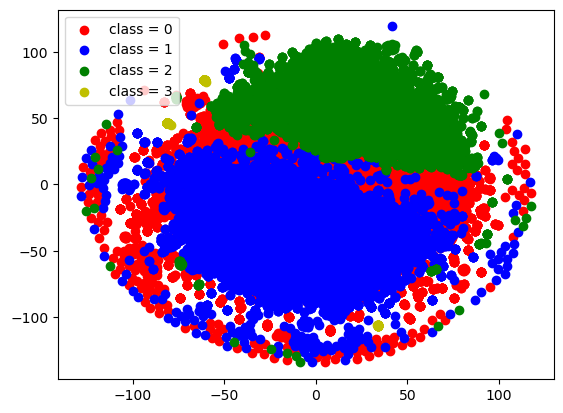

In [51]:
_, fig3, _ = plot_tsne(class_number, result, km.labels_)
fig3.savefig("../Report/pics/tsne_kmeans.png")

In [66]:
class_with_noise = 3
n = train_corpus.iloc[km.labels_==class_with_noise].shape[0]
print("Number element in cluster (K-means): ", n)
total_stat = total_stat.append({'models':'kmeans', 'class_size':n},ignore_index=True)

Number element in cluster (K-means):  413


/tmp/ipykernel_84837/2932100068.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_stat = total_stat.append({'models':'kmeans', 'class_size':n},ignore_index=True)


In [80]:
n_a = df.iloc[km.labels_==class_with_noise]["author_id"].unique().shape[0]
df_auth_stat = df_auth_stat.append({'models':'kmeans', 'number_of_authors':n_a},ignore_index=True)

/tmp/ipykernel_84837/627125377.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_auth_stat = df_auth_stat.append({'models':'kmeans', 'number_of_authors':n_a},ignore_index=True)


In [53]:
import codecs
LINE_WIDTH = 80
sub_indexes = np.random.randint(0,n,10)
with codecs.open("../Report/kmeansclasscomment.txt","w","utf-8-sig") as f:
    #f.write("\\begin{verbatim}")
    for w in train_corpus.iloc[km.labels_].iloc[sub_indexes]:
        print(w)
        print("----------------------------------\n")
        f.write((w[:LINE_WIDTH] + "...\n"))
        f.write("-------------------------------------------\n")
    #f.write("\\end{verbatim}")

Если бы мы не вели войска в Украину она бы напала на нас а Тиньков он клоун
----------------------------------

Z
----------------------------------

В деньгах силах. Есть деньги, есть комфорт, есть развитие, есть будущее.
----------------------------------

Z
----------------------------------

Z
----------------------------------

Если бы мы не вели войска в Украину она бы напала на нас а Тиньков он клоун
----------------------------------

Z
----------------------------------

Z
----------------------------------

В деньгах силах. Есть деньги, есть комфорт, есть развитие, есть будущее.
----------------------------------

В деньгах силах. Есть деньги, есть комфорт, есть развитие, есть будущее.
----------------------------------



In [54]:
# Общая статистика по классам

In [55]:
total_stat

,models,class_size
0,total,22661
1,GMM,976
2,out_circle,491
3,kmeans,413


In [56]:
total_stat.to_csv("total_stat.csv")

In [81]:
df_auth_stat

,models,number_of_authors
0,total,4267
1,GMM,319
2,out_circle,61
3,kmeans,255


In [82]:
df_auth_stat.to_csv("total_auth_stat.csv")